# Prediction <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

## Background

stuff

## Description
This notebook

### Load Packages

In [ ]:
# !pip install richdem
# !pip install https://packages.dea.ga.gov.au/hdstats/hdstats-0.1.5.tar.gz
# !pip install dask-ml

In [3]:
import sys
import datacube
import numpy as np
import xarray as xr
import subprocess as sp
from joblib import load
import matplotlib.pyplot as plt
from datacube.utils.cog import write_cog
from datacube.utils.geometry import assign_crs
from sklearn.preprocessing import StandardScaler
from odc.algo import xr_geomedian, int_geomedian

sys.path.append('../Scripts')
from deafrica_datahandling import load_ard
from deafrica_plotting import rgb, display_map
from deafrica_bandindices import calculate_indices
from deafrica_dask import create_local_dask_cluster
from deafrica_classificationtools import HiddenPrints
from deafrica_classificationtools import predict_xr, HiddenPrints

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

/env/lib/python3.6/site-packages/datacube/storage/masking.py:4: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)


### Set up a dask cluster
This will help keep our memory use down and conduct the analysis in parallel. If you'd like to view the dask dashboard, click on the hyperlink that prints below the cell. You can use the dashboard to monitor the progress of calculations.

In [4]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:36643 Dashboard: /user/chad/proxy/8787/status,Cluster Workers: 1 Cores: 15 Memory: 104.37 GB


## Analysis parameters

* `model_path`: The path to the location where the model exported from the previous notebook is stored
* `training_data`: Name and location of the training data `.txt` file output from runnning `1_Extract_training_data.ipynb`
* `features_scaled`: Use this parameter to indicate whether or not the features where scaled using the `standardScalar()` method in the previous notebook
* `sc_path`: If the `features_scaled` is set to `True`, then provide the path to the `standardScalar` values output in the previous notebook
* `locations`: A dictionary with values containing latitude and longitude points, and keys representing a unique ID to indetify the locations (these keys are used as filenames when exporting classifications as geotiffs).
* `buffer`: The number of degrees to load around the central latitude and longitude points in `locations`. This number here will depend on the compute/RAM available on the Sandbox instance, and the type and number of feature layers calculated. A value of `0.25` (which results in a 0.5 x 0.5 degree analysis extent) usually works well on the large sandbox instance.
* `results`: A location to store the classified geotiffs 

In [5]:
model_path = 'results/ml_model.joblib'

training_data = "results/training_data/test_training_data.txt"

features_scaled = False
sc_path = None #'results/std_scaler.bin'

test_locations = {
#              '1':(12.2636, 37.0244),
#              '2':(-0.2953, 38.4422),
#              '3':(11.5217, 37.4894),
#              '4':(-3.2838, 35.8406),
#              '5':(-0.3878, 37.4869),
#              '6':(-3.4866, 37.3650),
             '7':(-0.7062, 36.5865),
#              '8':(-0.6926, 35.6443)
            }

buffer = 0.15

results = 'results/classifications/'

### Find the number of cpus

In [6]:
try:
    ncpus = int(float(sp.getoutput('env | grep CPU')[-4:]))
except:
    ncpus = int(float(sp.getoutput('env | grep CPU')[-3:]))

print('ncpus = '+str(ncpus))

ncpus = 15


### Connect to the datacube

In [7]:
dc = datacube.Datacube(app='prediction')

## Open the model

If we ran the optional feature scaling method in the `3_Train_fit_evaluate_classifier.ipynb`, then we will also load in the standard scalar values.

The code below will also re-open the training data we exported from `2_Inspect_training_data.ipynb` and grab the column names (features we selected).

In [8]:
model = load(model_path)

if features_scaled:
    sc=load(sc_path)

In [9]:
# load the column_names
with open(training_data, 'r') as file:
    header = file.readline()
    
column_names = header.split()[2:]
print(column_names)

['red_S1', 'blue_S1', 'green_S1', 'nir_S1', 'swir_1_S1', 'edev_S1', 'bcdev_S1', 'NDVI_S1', 'LAI_S1', 'red_S2', 'blue_S2', 'green_S2', 'swir_1_S2', 'NDVI_S2', 'LAI_S2']


## Making a prediction


### 1. Redefining the feature layer function

How you define this function will depend on the steps you took in the previous notebooks.  If you elected to use the feature selection methods in `2_Inspect_training_data.ipynb` to reduce the number of features, then you may need to reconfigure the function to reduce the number of layers loaded (thereby reducing the time it takes to load and/or compute the feature layers). If you instead elected to use all the features extracted in `1_Extract_training_data.ipynb`, then you can simply copy-and-paste your `custom_training_data` function from the first notebook into the cell below.

In the default example, we can remove the `slope` load/calculation because we identified that feature layer as less important.  We also add an extra line that selects only those features we earlier indentified as the best features, i.e.:
                        
                       result = result[column_names]


In [10]:
from xr_geomedian_tmad import xr_geomedian_tmad

def two_seasons_gm_mads(ds, column_names):
    dc = datacube.Datacube(app='training')
    ds = ds / 10000
    ds1 = ds.sel(time=slice('2019-01', '2019-06'))
    ds2 = ds.sel(time=slice('2019-07', '2019-12')) 
    
    def fun(ds, era):
        
        #geomedian and tmads
        gm_mads = xr_geomedian_tmad(ds)
        gm_mads = calculate_indices(gm_mads,
                               index=['NDVI', 'LAI'],
                               drop=False,
                               normalise=False,
                               collection='s2')
        
        gm_mads['edev'] = -np.log(gm_mads['edev'])
        gm_mads['sdev'] = -np.log(gm_mads['sdev'])
        gm_mads['bcdev'] = -np.log(gm_mads['bcdev'])
        
        for band in gm_mads.data_vars:
            gm_mads = gm_mads.rename({band:band+era})
        
        return gm_mads
    
    epoch1 = fun(ds1, era='_S1')
    epoch2 = fun(ds2, era='_S2')
    
    result = xr.merge([epoch1,
                       epoch2],compat='override')
    
    # keep only the features we identified as useful
    # in the earlier notebooks
    result = result[column_names]

    return result.squeeze()

### 2. Set up datacube query

These query options should match the query params in `1_Extract_training_data.ipynb`, unless there are measurements that no longer need to be loaded because they were dropped during the feature selection process.

In [11]:
#set up our inputs to collect_training_data
products =  ['s2_l2a']
time = ('2019-01','2019-12')

# Set up the inputs for the ODC query
measurements =  ['red','blue','green','nir','swir_1']
resolution = (-20,20)
output_crs='epsg:6933'
dask_chunks={'x':1000,'y':1000,'time':1}

### 3. Loop through test locations and predict

For every location we list in the `test_locations` dictionary, we calculate the feature layers, and then use the DE Africa functions `predict_xr` and `predict_proba_xr` to classify the data.

The results are exported to file as Cloud-Optimised Geotiffs.

In [12]:
predictions = []
features = []

for key, latlon in test_locations.items():
    print("Working on : "+str(latlon))
    
    # generate a datacube query object
    query = {
        'x': (latlon[1]-buffer, latlon[1]+buffer),
        'y': (latlon[0]+buffer, latlon[0]-buffer),
        'time': time,
        'measurements': measurements,
        'resolution': resolution,
        'output_crs': output_crs,
        'group_by' : 'solar_day',
    }
    
    #load data
    with HiddenPrints():
        ds = load_ard(dc=dc,
                      products=products,
                      dask_chunks=dask_chunks,
                      min_gooddata=0.10,
                      **query)
        
    # calculate features
    data = two_seasons_gm_mads(ds, column_names)
    
    #predict using the imported model
    predicted = predict_xr(model, data, proba=True, persist=True, clean=True).compute()
    predictions.append(predicted)
    print('   loading features...')
    features.append(data.compute())
        
    #export data to disk
    write_cog(predicted.Predictions, results+ 'Eastern_tile'+key+'_prediction.tif', overwrite=True)
    write_cog(predicted.Probabilities, results+ 'Eastern_tile'+key+'_probability.tif', overwrite=True)


Working on : (-0.7062, 36.5865)
   predicting...
   probabilities...
  loading features...


## Plotting results

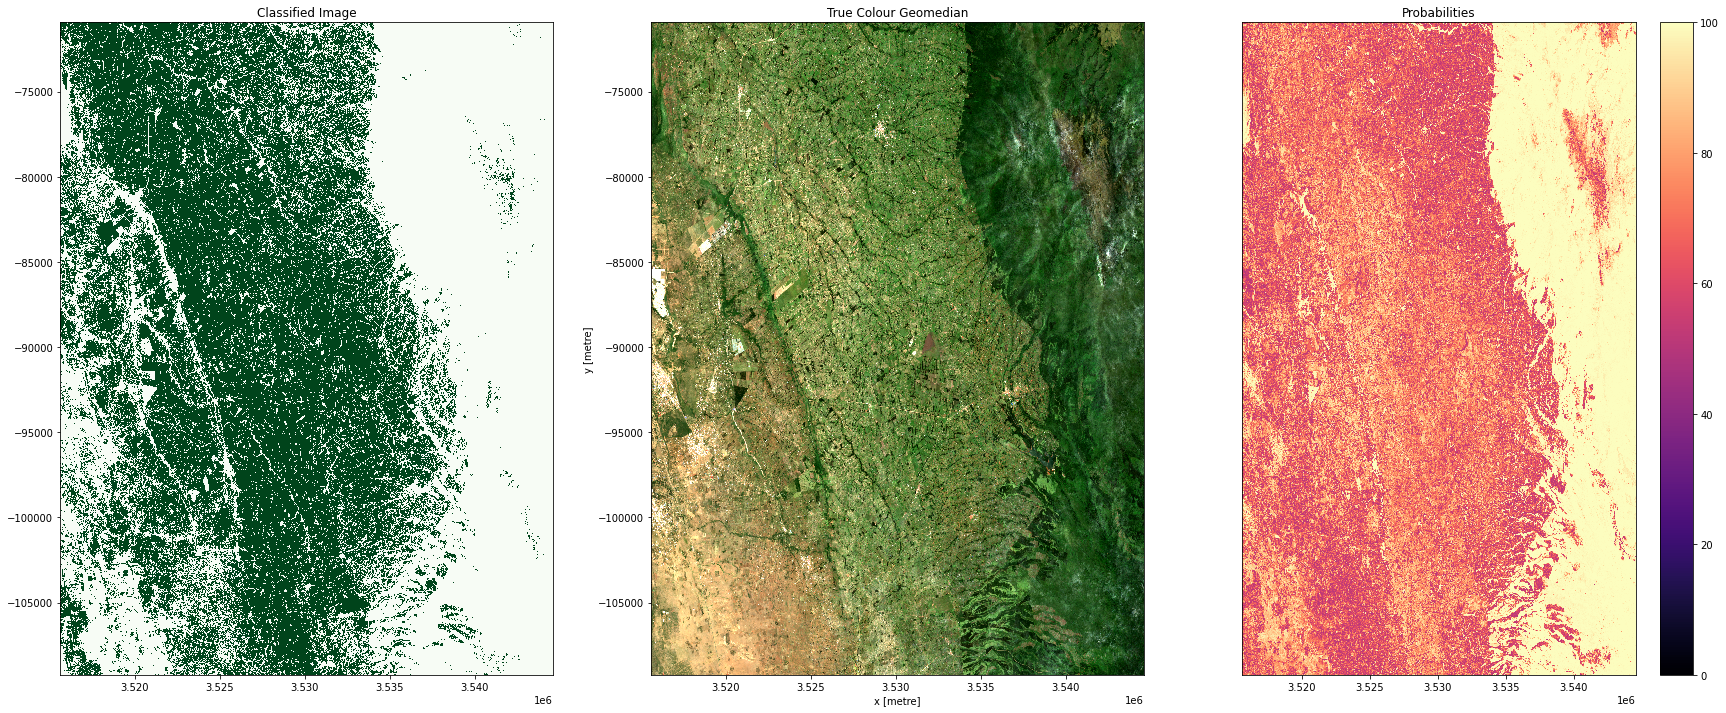

In [13]:
for i in range(0, len(predictions)):
    fig, axes = plt.subplots(1, 3, figsize=(30, 12))


    # Plot classified image
    predictions[i].Predictions.plot(ax=axes[0], 
                   cmap='Greens', 
                   add_labels=False, 
                   add_colorbar=False)

    # Plot true colour image
    rgb(features[i], bands=['red_S2','green_S2','blue_S2'],
        ax=axes[1], percentile_stretch=(0.01, 0.99))

    predictions[i].Probabilities.plot(ax=axes[2], 
                   cmap='magma',
                   vmin=0,
                   vmax=100,
                   add_labels=False, 
                   add_colorbar=True)

    # Remove axis on right plot
    axes[2].get_yaxis().set_visible(False)

    # Add plot titles
    axes[0].set_title('Classified Image')
    axes[1].set_title('True Colour Geomedian')
    axes[2].set_title('Probabilities');

## Large scale classification

If you're happy with the results of the test locations, then attempt to classify a large region by re-entering a new latitude, longitude and larger buffer size. You may need to adjust the `dask_chunks` size to optimize for the larger region.

In [14]:
del ds
del predictions
del features

In [15]:
new_lat, new_lon = -0.2820, 37.0690
new_buffer = 1.25
dask_chunks={'x':1500,'y':1500,'time':1}
name='Kenya'

In [16]:
display_map((new_lon-new_buffer, new_lon+new_buffer), (new_lat+new_buffer, new_lat-new_buffer))

In [17]:
%%time

# generate a datacube query object
query = {
    'x': (new_lon-new_buffer, new_lon+new_buffer),
    'y': (new_lat+new_buffer, new_lat-new_buffer),
    'time': time,
    'measurements': measurements,
    'resolution': resolution,
    'output_crs': output_crs,
    'group_by' : 'solar_day',
}

#load data
ds = load_ard(dc=dc,
              products=products,
              dask_chunks=dask_chunks,
              **query)

# calculate features (don't compute, let predict_xr do that)
features = two_seasons_gm_mads(ds, column_names)

#predict using the imported model
predicted = predict_xr(model, features, proba=False, persist=False, clean=True).compute()

write_cog(predicted.Predictions, results+ 'Eastern_tile_'+name+'_prediction.tif', overwrite=True)
# write_cog(predicted.Probabilities, results+ 'Eastern_tile_'+name+'_probabilities.tif', overwrite=True)

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Applying pixel quality/cloud mask
Returning 145 time steps as a dask array
   predicting...
CPU times: user 30min 8s, sys: 1min 35s, total: 31min 44s
Wall time: 1h 53min 50s


PosixPath('results/classifications/Eastern_tile_Kenya_prediction.tif')

In [18]:
predicted

<xarray.Dataset>
Dimensions:      (x: 12061, y: 15946)
Coordinates:
  * x            (x) float64 3.456e+06 3.456e+06 ... 3.697e+06 3.697e+06
  * y            (y) float64 1.235e+05 1.235e+05 ... -1.954e+05 -1.954e+05
    spatial_ref  int32 0
Data variables:
    Predictions  (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0 1.0
Attributes:
    grid_mapping:  spatial_ref

In [23]:
fig, axes = plt.subplots(1, 1, figsize=(30, 15))

# Plot classified image
predicted.Predictions.plot(ax=axes[0], 
               cmap='Greens', 
               add_labels=False, 
               add_colorbar=False)

predicted.Probabilities.plot(ax=axes[1], 
               cmap='magma',
               vmin=0,
               vmax=100,
               add_labels=False, 
               add_colorbar=True)

Remove axis on right plot
axes[1].get_yaxis().set_visible(False)

Add plot titles
axes[0].set_title('Classified Image')
axes[1].set_title('Probabilities');

CUTS

In [ ]:
        #band indices
#         bi = calculate_indices(ds,
#                                index=['EVI', 'LAI'],
#                                drop=True,
#                                normalise=False,
#                                collection='s2')
        
#         bi_max = bi.max('time')
#         bi_min = bi.min('time')
#         bi_range = bi_max - bi_min
#         bi_range = bi_range.rename({'EVI':'EVI_range','LAI':'LAI_range'})
#         bi_max = bi_max.rename({'EVI':'EVI_max','LAI':'LAI_max'})
#         bi_min = bi_min.rename({'EVI':'EVI_min','LAI':'LAI_min'})
#  out = xr.merge([gm_mads,bi_max,bi_min,bi_range],compat='override')